# Analysis of HSM/P predictions of 'gold standard' & human proteome PPIs

In [1]:
import os
import json
import numpy as np
import pandas as pd
from scipy.stats import combine_pvalues
from statsmodels.stats.multitest import multipletests
import operator

from scripts.utils import load_hsmd, load_model_threshold_fpr, load_prots, strip_isoform_uniprotid, output_data_json

## Recall vs FDR for 'gold standard' (Fig 2b and Table S5)

In [2]:
def obtain_hsmp_pvalues(dpi_probs, directory='data/perf/hsmd'):
    "Compute HSM/P p-values from combined HSM/D p-values."   
    model_fpr_t = load_model_threshold_fpr(directory)
  
    ps = []
    for dpi_prob in dpi_probs:
        fprs = []
        for dpi in dpi_prob:
            ndx = np.argmin(np.abs(dpi[1] - model_fpr_t[dpi[0]][:,1]))
            fprs.append(model_fpr_t[dpi[0]][ndx, 0])
        chi, p = combine_pvalues(fprs, method='fisher')
        ps.append(p)

    return np.array(ps)

def obtain_hsmd_pvals(dpi_probs, directory='data/perf/hsmd'):
    "Obtain p-values for each domain-peptide interaction."
    model_fpr_t = load_model_threshold_fpr(directory)

    ps = []
    for dpi_prob in dpi_probs:
        fprs = []
        for dpi in dpi_prob:
            ndx = np.argmin(np.abs(dpi[1] - model_fpr_t[dpi[0]][:,1]))
            fprs.append(model_fpr_t[dpi[0]][ndx, 0])
        ps.append(np.array(fprs))

    return ps

def number_found_in_baits(fbait, prots):
    "Compute number of proteins found in list of baits."
    baits = strip_isoform_uniprotid(np.loadtxt(fbait, dtype=str))
    mask = (np.isin(prots, baits).sum(axis=1) > 0)
    return float(sum(mask)), baits

def number_found_in_y2h(fy2h, prots):
    "Compute number of proteins found in list of yeast two-hybrid proteins."
    baits = strip_isoform_uniprotid(np.loadtxt(fy2h, dtype=str, delimiter=',').flatten())
    mask = (np.isin(prots, baits).sum(axis=1) > 1)
    return float(sum(mask)), baits

def calc_recall_fdr_bh(pvals, fname):
    "Compute FDR vs recall curve."
    alphas = np.arange(0, 1, 0.0005)
    recalls = np.zeros(len(alphas))
    for i, a in enumerate(alphas):
        reject, _, _, _ = multipletests(pvals, alpha=a, method='fdr_bh')
        recalls[i] = sum(reject)/float(len(pvals))

    pd.DataFrame({'FDR': alphas, 'Recall': recalls}).to_csv(fname, index=False)

    #print(max(pvals[reject]))
    return alphas, recalls

### Experimental PPI datasets

In [3]:
# directory with experimental PPI datasets
ppi_exp_dir = '../data/ppi_data/ppi_expt_comparisons'

# High-throughput experimental PPIs
expt_names = ['HT-VIDAL', 'HT-Mann', 'HT-Mann HC', 'HT-GYGI']
pred_ppi_files = ['rolland_vidal_interactions.csv',
                  'heinn_mann_interactions.csv',
                  'heinn_mann_interactions.high_confidence.csv',
                  'bioplex_interactions.csv']
bait_files = ['rolland_vidal_interactions.csv',
              'heinn_mann_baits.txt',
              'heinn_mann_baits.txt',
              'bioplex_baits.txt']
max_recall_fcn = [number_found_in_y2h, number_found_in_baits, number_found_in_baits, number_found_in_baits]
# FDRs from publications
expt_fdrs = [0.01, 0.05, 0.01, 0.01]

#### 'Gold standard' dataset

In [4]:
# 'gold standard' PPIs
gold = os.path.join(ppi_exp_dir, 'pv_lt_lit.interactions.csv')
# 'gold standard' PPIs filtered to remove any overlap with HSM training data
gold_filtered = os.path.join(ppi_exp_dir, 'filtered_pv_lt_lit.interactions.csv')
                             
gold1d, gold2d = load_prots(gold)
print("gold standard has %i pairs" % len(gold1d))
gf1d, gf2d = load_prots(gold_filtered)
print("filtered gold standard has %i pairs\n" % len(gf1d))

gold standard has 33042 pairs
filtered gold standard has 31888 pairs



#### High-throughput experiments evaluated on 'gold standard'

In [5]:
expt_datasets = {}
expt_recall_fdr = {}

def evaluate_expt(name, fppi, fbait, max_recall_fcn, gold2d=gold2d, gold1d=gold1d):
    n, baits = max_recall_fcn(fbait, gold2d)
    prots1d, prots2d = load_prots(fppi)
    npos = np.sum(np.isin(prots1d, gold1d))
    print('%s' % name)
    print(" Reported interactions:", len(prots1d))
    print(" Number of proteins: %i" % len(np.unique(prots2d.flatten())))
    print(" Number of true positives based on gold:", npos)
    print(" Number of gold possible to detect:", n)
    print(" Recall of gold:", npos/n, "\n")
    
    return prots1d, npos/n

for name, fppi, fbait, fcn, fdr in zip(expt_names, pred_ppi_files, bait_files, max_recall_fcn, expt_fdrs):
    fp = os.path.join(ppi_exp_dir, fppi)
    fb = os.path.join(ppi_exp_dir, fbait)
    d, recall = evaluate_expt(name, fp, fb, fcn)
    expt_datasets[name] = d
    expt_recall_fdr[name] = [fdr, recall]

HT-VIDAL
 Reported interactions: 13944
 Number of proteins: 4204
 Number of true positives based on gold: 458
 Number of gold possible to detect: 3465.0
 Recall of gold: 0.13217893217893217 

HT-Mann
 Reported interactions: 27963
 Number of proteins: 5351
 Number of true positives based on gold: 1060
 Number of gold possible to detect: 11222.0
 Recall of gold: 0.09445731598645518 

HT-Mann HC
 Reported interactions: 14240
 Number of proteins: 4281
 Number of true positives based on gold: 1293
 Number of gold possible to detect: 11222.0
 Recall of gold: 0.11522010336838354 

HT-GYGI
 Reported interactions: 56416
 Number of proteins: 10883
 Number of true positives based on gold: 1414
 Number of gold possible to detect: 18233.0
 Recall of gold: 0.07755169198705644 



### HSM/P predictions on 'gold standard'

In [6]:
# HSM predictions for each PPI pair in gold standard filtered
f_hsmp_dpi_preds = '../predictions/gold_standard/outputs/dpi_predictions.txt'
hsmp_gold_prots1d, hsmp_gold_prots2d, hsmp_gold_dpiprobs, hsmp_gold_dpidata = load_hsmd(f_hsmp_dpi_preds)

# convert HSM/D predictions to p-values for each PPI
hsmp_gold_pvals = obtain_hsmp_pvalues(hsmp_gold_dpiprobs)

output_directory = 'data/perf/hsmp'
if not os.path.exists(output_directory): os.makedirs(output_directory)

# calc recall vs FDR
recall_fdr = calc_recall_fdr_bh(hsmp_gold_pvals, os.path.join(output_directory, 'hsm_gold_standard_recall_fdr.csv'))

/Users/juliarogers/miniforge3/envs/py39-veclib/lib/python3.9/site-packages/scipy/stats/_stats_py.py:8161: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * np.sum(np.log(pvalues))


#### Fig 2b plot

In [7]:
%matplotlib inline
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gs
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

sns.set_style("white")

plt.rcParams['font.size'] = 13
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Calibri'
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.handlelength'] = 1.3

plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

plt.rcParams['lines.dashed_pattern'] = (2.8,2.8)

plt.rcParams['svg.fonttype'] = 'none'


blue = "#007EEA"
orange = "#FEB80A"
green = "#7FD13B"
pink = "#EA157A"
white = "#FFFFFF"
purple = "#754AB2"
black = "#000000"

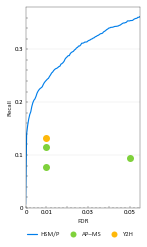

In [8]:
def plot_recall_fdr(hsm_curve, expt_names, expt_recall_fdr, expt_colors):
    plt.plot(hsm_curve[0], hsm_curve[1], color=blue, lw=2.5)
    
    for name in expt_names:
        plt.plot(expt_recall_fdr[name][0], expt_recall_fdr[name][1],
                 marker="o", markersize=15, markerfacecolor=expt_colors[name], markeredgewidth=0.0)
    
    plt.xlim([0, 0.06])
    plt.ylim([0, 0.38])
    plt.xlabel('FDR')
    plt.ylabel('Recall')
    plt.show()


labels_size=7
tic_size=6.75
line_width=1.14
marker_size=7
def plot_recall_fdr_subplot(hsm_curve, ax, expt_names, expt_recall_fdr, expt_colors,
                        labels_size=labels_size, tic_size=tic_size, lw=line_width, markersize=marker_size):
    
    ax.plot(hsm_curve[0], hsm_curve[1], color=blue, lw=lw)
        
    for name in expt_names:
        ax.plot(expt_recall_fdr[name][0], expt_recall_fdr[name][1],
                marker="o", markersize=markersize, markerfacecolor=expt_colors[name], markeredgewidth=0.0)
        
    ax.set_xlim([0,0.055])
    ax.set_ylim([0,0.38])
    ax.set_xticks(np.arange(0,0.055,0.01))
    ax.set_yticks(np.arange(0,0.38,0.1))
    show_xtics = [0, 0.01, 0.03, 0.05]

    # Pretty formatting of the ticks axes.      
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "  0" if x < 1e-7 else (str(x)[:8].rstrip('0') if x in show_xtics else "")))
    minorLocatorX = AutoMinorLocator()
    ax.xaxis.set_minor_locator(minorLocatorX)
    ax.tick_params(axis='x', which='major', direction='in', bottom=True, left=True, width=0.3, length=2.4, labelsize=tic_size, pad=2)
    ax.tick_params(axis='x', which='minor', direction='in', bottom=True, left=True, width=0.3, length=1.5)
    
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "0" if x < 1e-7 else str(x)[:8].rstrip('0')))
    minorLocatorY = AutoMinorLocator()
    ax.yaxis.set_minor_locator(minorLocatorY)
    ax.tick_params(axis='y', which='major', direction='in', bottom=True, left=True, width=0.3, length=2.4, labelsize=tic_size, pad=2)
    ax.tick_params(axis='y', which='minor', direction='in', bottom=True, left=True, width=0.3, length=1.5)
    
    # Sets grid
    ax.grid(which='major', axis='y', color='#DCDCDC', linewidth=0.3)
    for a in ['top', 'bottom', 'left', 'right']:
        ax.spines[a].set_linewidth(0.3)
    
scale_x = 1.285
scale_y = 1.305
h = (1.352*scale_y)*2 + 0.089*scale_y
plot_specs = {
    'fig_top': 0.0, 'fig_bot': 0.05, 'fig_left': 0.04, 'fig_right': 0.0,
    'subplot_height': h, 'subplot_width': 2.01,
    'subplot_wspace': 0, 'subplot_hspace': 0,
    'ncols': 1, 'nrows': 1}

def get_plot_specs(plot_specs):
    xsize = plot_specs['fig_left'] + plot_specs['fig_right'] + plot_specs['subplot_width']*plot_specs['ncols'] + (plot_specs['ncols']-1)*plot_specs['subplot_wspace']
    ysize = plot_specs['fig_top'] + plot_specs['fig_bot'] + plot_specs['subplot_height']*plot_specs['nrows'] + (plot_specs['nrows']-1)*plot_specs['subplot_hspace']
    return xsize, ysize

xsize, ysize = get_plot_specs(plot_specs)
gs_kw = {'wspace': plot_specs['subplot_wspace']/plot_specs['subplot_width'],
        'hspace': plot_specs['subplot_hspace']/plot_specs['subplot_height']}

fig, axes = plt.subplots(plot_specs['nrows'], plot_specs['ncols'], figsize=(xsize, ysize), gridspec_kw=gs_kw)
expt_colors = {'HT-VIDAL': orange, 'HT-Mann': green, 'HT-Mann HC': green, 'HT-GYGI': green}
plot_recall_fdr_subplot(recall_fdr, axes, expt_names, expt_recall_fdr, expt_colors)
    
axes.set_xlabel("FDR", fontsize=labels_size, labelpad=plot_specs['fig_bot']*72)
axes.set_ylabel("Recall", fontsize=labels_size, labelpad=plot_specs['fig_left']*72)
 
# Creates legend with appropriate linestyles / colors / etc. 
linestyles = [Line2D([0], [0], color=blue, lw=1.2, ls='-'),
              Line2D([0], [0], ls='', marker="o", markersize=6, markerfacecolor=green, markeredgewidth=0.0),
              Line2D([0], [0], ls='', marker="o", markersize=6, markerfacecolor=orange, markeredgewidth=0.0)]
fig.legend(linestyles, ["HSM/P", "AP–MS", "Y2H"], 
           loc='lower left', bbox_to_anchor=[0.125,0.01], ncol=3, columnspacing=1.2,
           frameon=False, handlelength=1.5, fontsize=tic_size, borderaxespad=-0.2, handletextpad=0.5)

output_directory = "plots/fig_2_supp_fig_3/"
if not os.path.exists(output_directory): os.makedirs(output_directory)
fig.savefig(os.path.join(output_directory, "gold_standard_comparison.pdf"), dpi=500, transparent=True, bbox_inches='tight')

## Analysis of HSM predicted PPIs in human proteome confirmed by experiment

Load all HSM/P predictions at proteome scale and save them with their HSM/P p-values noted.

In [9]:
# HSM proteome predictions
f_hsmp_dpi_preds = '../predictions/hsmp_new/outputs/dpi_predictions.txt'
hsmp_prots1d, hsmp_prots2d, hsmp_dpiprobs, hsmp_dpidata = load_hsmd(f_hsmp_dpi_preds)
f_hsmp_ppi_preds = '../predictions/hsmp_new/outputs/ppi_predictions.csv'
hsmp_probs = np.loadtxt(f_hsmp_ppi_preds, delimiter=',', usecols=(2,), dtype=str)
# remove those failed to predict HSM/P probability due to compute limits (2 s per PPI)
ndxs = np.where(hsmp_probs != '"Timeout Error')[0]
hsmp_probs = hsmp_probs[ndxs].astype(float)
hsmp_prots1d, hsmp_prots2d = hsmp_prots1d[ndxs], hsmp_prots2d[ndxs]
hsmp_dpiprobs = [hsmp_dpiprobs[i] for i in ndxs]
hsmp_dpidata = [hsmp_dpidata[i] for i in ndxs]

In [10]:
# convert HSM/D predictions to p-values for each PPI
hsmp_pvals = obtain_hsmp_pvalues(hsmp_dpiprobs)
df = pd.DataFrame({'Protein 1': hsmp_prots2d[:,0],
                   'Protein 2': hsmp_prots2d[:,1],
                   'HSM/P probability': hsmp_probs,
                   'p-value': hsmp_pvals})
output_directory = 'data/perf/hsmp'
df.to_csv(os.path.join(output_directory,'ppi_predictions_pvals.csv'), index=False)

/Users/juliarogers/miniforge3/envs/py39-veclib/lib/python3.9/site-packages/scipy/stats/_stats_py.py:8161: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * np.sum(np.log(pvalues))


Plotting how HSM/P predicted probabilities compare to p-values derived from HSM/D predictions

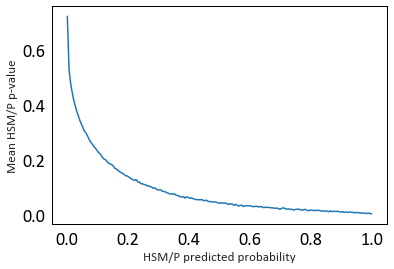

HSM/P predicted probability of 0.697502425836604 corresponds to a mean p-value of  0.01859782382555067
HSM/P predicted probability of 0.8674893390531991 corresponds to a mean p-value of  0.009990674584888604


In [11]:
bins = np.arange(0, 1.005, 0.005)
binned_ndxs = np.digitize(hsmp_probs, bins)
mprob = np.array([np.mean(hsmp_probs[binned_ndxs == i]) for i in np.unique(binned_ndxs)])
mpval = np.array([np.mean(hsmp_pvals[binned_ndxs == i]) for i in np.unique(binned_ndxs)])
maxpval = [np.max(hsmp_pvals[binned_ndxs == i]) for i in np.unique(binned_ndxs)]
plt.plot(mprob, mpval)
plt.xlabel('HSM/P predicted probability')
plt.ylabel('Mean HSM/P p-value')
plt.show()

i = np.argmin(np.abs(mprob - 0.7))
print("HSM/P predicted probability of", mprob[i], "corresponds to a mean p-value of ", mpval[i])

i = np.argmin(np.abs(mpval - 0.01))
print("HSM/P predicted probability of", mprob[i], "corresponds to a mean p-value of ", mpval[i])

HSM/P predictions at FDR of 0.01 are considered predicted PPIs.

In [12]:
# HSM/P predicted PPIs at FDR of 0.01
reject, _, _, _ = multipletests(hsmp_pvals, alpha=0.01, method='fdr_bh')
ndxs = np.where(reject)[0]
ppi_pvals, ppi_probs = hsmp_pvals[ndxs], hsmp_probs[ndxs]
print("Max p-value at FDR of 0.01:", max(ppi_pvals))
print("Mean p-value at FDR of 0.01:", np.mean(ppi_pvals))
print("Min HSM/P probability at FDR of 0.01:", min(ppi_probs))
print("Mean HSM/P probability at FDR of 0.01:", np.mean(ppi_probs))
ppis, ppis2d = hsmp_prots1d[ndxs], hsmp_prots2d[ndxs]
ppi_dpiprobs = [hsmp_dpiprobs[i] for i in ndxs]
ppi_dpidata = [hsmp_dpidata[i] for i in ndxs]

Max p-value at FDR of 0.01: 0.0003010740025014211
Mean p-value at FDR of 0.01: 6.432994898268898e-05
Min HSM/P probability at FDR of 0.01: 0.15168957990231446
Mean HSM/P probability at FDR of 0.01: 0.8126993686100453


### Comparison to experimental datasets

Data 'pre HSM training' includes:
* **For protein pairs *without* a possible kinase-pY interaction:**
    * BioGRID 3.2.120 release (12/25/2014)
    * HT-VIDAL (publication date: 2014)
* **For protein pairs *with* a possible kinase-pY interaction:**
    * BioGRID 4.4.213 release (8/25/2022)
    * HT-VIDAL, HT-MANN, HT-GYGI

Data 'post HSM training' includes:
* **For protein pairs *without* a possible kinase-pY interaction:**
    * All repored in BioGRID 4.4.216 release (11/25/2022) and not in BioGRID 3.2.120
    * HT-MANN, HT-GYGI
* **For protein pairs *with* a possible kinase-pY interaction:**
    * All reported in BioGRID 4.4.216 release (11/25/2022) and not in BioGRID 4.4.213

In [13]:
# BioGRID data
biogrid_releases = ['3.2.120', '4.4.213', '4.4.216']
for release in biogrid_releases:
    fp = os.path.join(ppi_exp_dir, 'biogrid%s.csv' % release)
    biogrid, _ = load_prots(fp)
    biogrid = np.unique(biogrid)
    print("BioGRID data has %10i PPIs in release %s" % (len(biogrid), release))
    expt_datasets['BioGRID %s' % release] = biogrid

r1 = biogrid_releases[-1]
for r0 in biogrid_releases[:-1]:
    mask = np.isin(expt_datasets['BioGRID %s' % r1], expt_datasets['BioGRID %s' % r0])
    post = expt_datasets['BioGRID %s' % r1][~mask]
    print("BioGRID data has %10i PPIs in release %s not in release %s" % (len(post), r1, r0))
    expt_datasets['BioGRID %s-%s' % (r0, r1)] = post

# final sets for experimental validation
def combine_expt_sets(names):
    d = [d for k, d in expt_datasets.items() if k in names]
    return np.concatenate(d)

def create_expt_slits(post_names, pre_names):
    post_prots = combine_expt_sets(post_names)
    pre_prots = combine_expt_sets(pre_names)
    mask = np.isin(post_prots, pre_prots)
    return np.unique(pre_prots), np.unique(post_prots[~mask])

nontk_post_names = ['BioGRID 3.2.120-4.4.216', 'HT-Mann', 'HT-GYGI']
nontk_pre_names = ['BioGRID 3.2.120', 'HT-VIDAL']
nontk_pre_prots, nontk_post_prots = create_expt_slits(nontk_post_names, nontk_pre_names)
print(" %10i PPIs post HSM data for confirmation of HSM predictions without kinases\n(%10i pre HSM data)" % (len(nontk_post_prots), len(nontk_pre_prots)))

tk_post_names = ['BioGRID 4.4.213-4.4.216']
tk_pre_names = ['BioGRID 4.4.213', 'HT-VIDAL', 'HT-Mann', 'HT-GYGI']
tk_pre_prots, tk_post_prots = create_expt_slits(tk_post_names, tk_pre_names)
print("\n %10i PPIs post HSM data for confirmation of HSM predictions with kinases\n(%10i pre HSM data)" % (len(tk_post_prots), len(tk_pre_prots)))


BioGRID data has     157565 PPIs in release 3.2.120
BioGRID data has   22144848 PPIs in release 4.4.213
BioGRID data has   22758776 PPIs in release 4.4.216
BioGRID data has   22616840 PPIs in release 4.4.216 not in release 3.2.120
BioGRID data has     613928 PPIs in release 4.4.216 not in release 4.4.213
   22630128 PPIs post HSM data for confirmation of HSM predictions without kinases
(    159065 pre HSM data)

     613917 PPIs post HSM data for confirmation of HSM predictions with kinases
(  22159782 pre HSM data)


In [14]:
# split HSM/P predicted PPIs based on kinase and non-kinase

from scripts.utils import load_protein_metadata, get_protein_composition, get_ppi_composition
metadata = load_protein_metadata()

mask_tk = np.zeros(len(ppis), dtype=bool)
for i, data in enumerate(ppi_dpidata):
    p1, p2, interactions = data
    c1, c2 = get_ppi_composition(p1, p2, interactions, np.zeros(len(interactions)), metadata=metadata)
    u1 = [c[0] for c in c1]
    u2 = [c[0] for c in c2]
    if ('Kinase_TK' in u1 and 'phosphosite' in u2) or ('Kinase_TK' in u2 and 'phosphosite' in u1):
        mask_tk[i] = True

Determine number of PPIs predicted by HSM and verified experimentally. This information is saved and made available.

In [15]:
# HSM/P predicted PPIs confirmed by experiment after HSM training data collected
# PPIs w/o kinases
mask_confirmed_nontk = np.isin(ppis, nontk_post_prots)
ndxs_nontk = np.where(np.logical_and(~mask_tk, mask_confirmed_nontk))[0]

# PPIs w/ kinases
mask_confirmed_tk = np.isin(ppis, tk_post_prots)
ndxs_tk = np.where(np.logical_and(mask_tk, mask_confirmed_tk))[0]

confirmed_ndxs = np.concatenate([ndxs_nontk, ndxs_tk])
confirmed_ppis, confirmed_ppis2d = ppis[confirmed_ndxs], ppis2d[confirmed_ndxs]
confirmed_dpiprobs = [ppi_dpiprobs[i] for i in confirmed_ndxs]
confirmed_dpidata = [ppi_dpidata[i] for i in confirmed_ndxs]
# HSM/D p-vals for each PBD-SLiM interaction in each confirmed PPI
pvals = obtain_hsmd_pvals(confirmed_dpiprobs)
# HSM/P predicted probabilities
confirmed_probs = ppi_probs[confirmed_ndxs]

# HSM/P predicted PPIs not yet confirmed when HSM training data collected
# PPIs w/o kinases
mask_pre_nontk = np.isin(ppis, nontk_pre_prots)
ndxs_nontk = np.where(np.logical_and(~mask_tk, ~mask_pre_nontk))[0]

# PPIs w/ kinases
mask_pre_tk = np.isin(ppis, tk_pre_prots)
ndxs_tk = np.where(np.logical_and(mask_tk, ~mask_pre_tk))[0]

pre_ndxs = np.concatenate([ndxs_nontk, ndxs_tk])
print("\n %10i PPIs predicted by HSM not in combined protein-level data before time of split" % len(pre_ndxs))
print("(%10i total predicted by HSM)" % len(ppis))

# output metadata including:
#   If confirmed after HSM training data collected
#   Experimental confirmation source

expt_confirmation = [[] for i in range(len(ppis))]

print("\nHSM predicts %10i PPIs reported in HT experiments\n" % len(confirmed_ppis))
for name, prots in expt_datasets.items():
    n = np.sum(np.isin(confirmed_ppis, prots))
    print("HSM predicts %10i PPIs reported in %s and confirmed after the split" % (n, name))
    if name in ['BioGRID 3.2.120-4.4.216', 'BioGRID 4.4.213-4.4.216']: continue
    mask = np.isin(ppis, prots)
    for i in np.where(mask)[0]:
        expt_confirmation[i].append(name)
expt_confirmation = ['|'.join(e) for e in expt_confirmation]
post_confirmed = ['yes' if i in confirmed_ndxs else 'no' if len(expt_confirmation[i]) > 0 else '' for i in range(len(ppis))]

df = pd.DataFrame({'Protein 1': ppis2d[:,0],
                   'Protein 2': ppis2d[:,1],
                   'HSM/P probability': ppi_probs,
                   'p-value': ppi_pvals,
                   'Experimental confirmation source': expt_confirmation,
                   'Confirmed after HSM training data collected': post_confirmed})
df.to_csv(os.path.join(output_directory,'ppi_predictions.fdr0.01.csv'), index=False)


     140236 PPIs predicted by HSM not in combined protein-level data before time of split
(    143215 total predicted by HSM)

HSM predicts        865 PPIs reported in HT experiments

HSM predicts          0 PPIs reported in HT-VIDAL and confirmed after the split
HSM predicts         22 PPIs reported in HT-Mann and confirmed after the split
HSM predicts         12 PPIs reported in HT-Mann HC and confirmed after the split
HSM predicts         67 PPIs reported in HT-GYGI and confirmed after the split
HSM predicts          0 PPIs reported in BioGRID 3.2.120 and confirmed after the split
HSM predicts        799 PPIs reported in BioGRID 4.4.213 and confirmed after the split
HSM predicts        854 PPIs reported in BioGRID 4.4.216 and confirmed after the split
HSM predicts        854 PPIs reported in BioGRID 3.2.120-4.4.216 and confirmed after the split
HSM predicts         55 PPIs reported in BioGRID 4.4.213-4.4.216 and confirmed after the split


### Analyze PBD-SLiM interactions in these experimentally confirmed PPIs

All analysis performed on 'high-confidence' PBD-SLiM interactions defined as HSM/D p-val $\le$ 0.05

In [16]:
def count_high_confidence_dpi_per_ppi(ps, threshold=0.05, threshold_operator=np.less_equal):
    "Return indices of high confidence PBD-SLiM interactions per PPI based on threshold"
    counts = np.zeros(len(ps))
    ndxs = []
    for i, p in enumerate(ps):
        ndx = np.where(threshold_operator(p, threshold))[0]
        counts[i] = (len(ndx))
        ndxs.append(ndx)

    nppis = len(ps)/100.0
    n = len(counts[counts >= 1])
    print("Number PPIs with >= 1 high confidence PBD-SLiM interactions: %i (%.1f%%)" % (n, n/nppis))
    n = len(counts[counts >= 2])
    print("Number PPIs with >= 2 high confidence PBD-SLiM interactions: %i (%.1f%%)" % (n, n/nppis))

    # also return # of PPIs with at least 1 high affinity interaction
    return ndxs, len(counts[counts >= 1])

In [17]:
def count_num_confident_doms(data, ps, threshold=0.05, threshold_operator=np.less_equal, threshold_multidentate=2):
    "Count number of high confidence PBDs in each PPI"
    
    count_per_ppi = []
    for p, (uid1, uid2, interactions) in zip(ps, data):
        count_per_ppi.append(len(set(i[0][1] for ip, i in zip(p, interactions) if threshold_operator(ip, threshold))))
        
    plt.hist(count_per_ppi, bins=[i for i in range(max(count_per_ppi)+1)], align='left')
    plt.xlabel('Number of high confidence PBDs per PPI')
    plt.ylabel('Count')
    plt.title('High confidence threshold %.3f' % threshold)
    plt.show()
    
    return sum([1 for c in count_per_ppi if c >= threshold_multidentate])

In [18]:
def count_num_multidentate_domain_or_peptide(data, ps, dp='peptide', threshold=0.05, threshold_operator=np.less_equal,
                                             threshold_multidentate=2, exclusive=True):
    "Count number of peptides (domains) in each PPI that have high confidence interactions with multiple domains (peptides)"
    
    if dp == 'peptide': index = 1
    else: index = 0
        
    count_per_ppi = []
    for p, (uid1, uid2, interactions) in zip(ps, data):
        seq_counts = {} # number of domains (peptides) that each peptide (domain) interacts with
        for ip, i in zip(p, interactions):
            if threshold_operator(ip, threshold):
                seq = i[index][1]
                if seq not in seq_counts.keys(): seq_counts[seq] = 0
                seq_counts[seq] += 1
        count_per_ppi.append(sum([1 for v in seq_counts.values() if v >= threshold_multidentate]))
        
    plt.hist(count_per_ppi, bins=[i for i in range(max(count_per_ppi)+1)], align='left')
    plt.xlabel('Number of multidendate %s per PPI' % dp)
    plt.ylabel('Count')
    plt.title('High confidence threshold %.3f' % threshold)
    plt.show()
    
    # return number with exactly 1 multidendate peptide/domain
    if exclusive: return sum(1 for c in count_per_ppi if c == 1)
    
    # return number with at least 1 multidendate peptide/domain
    else: return sum(1 for c in count_per_ppi if c >= 1)

In [19]:
def count_chemistry(data, ps, threshold=0.05, threshold_operator=np.less_equal):
    "Count number of interactions involving a given chemistry per PPI"
        
    count_per_ppi = {} # number of interactions of each chemistry per PPI
    ppi_chemcombos = {} # number of PPIs with each possible combination of chemistries
    ppi_multichem = 0 # number of PPIs with multiple chemistries
    for p, (uid1, uid2, interactions) in zip(ps, data):
        chem_counts = {} # number of interactions of each chemistry
        for ip, i in zip(p, interactions):
            if threshold_operator(ip, threshold):
                chem = i[1][0]
                if chem not in chem_counts.keys(): chem_counts[chem] = 0
                chem_counts[chem] += 1
        for k, v in chem_counts.items():
            if k not in count_per_ppi.keys(): count_per_ppi[k] = []
            count_per_ppi[k].append(chem_counts[k])
        if len(chem_counts.keys()) > 1: ppi_multichem += 1
        combo = ','.join(sorted(chem_counts.keys()))
        if combo not in ppi_chemcombos.keys(): ppi_chemcombos[combo] = 0
        ppi_chemcombos[combo] += 1
    
    # histograms of number of interaction with given chemistry per PPI
    fig, axs = plt.subplots(1, len(count_per_ppi.keys()), constrained_layout=True, figsize=(5*len(count_per_ppi.keys()),3))
    for i, (k, vals) in enumerate(count_per_ppi.items()):
        axs[i].hist(vals, bins=[j for j in range(max(vals)+1)], align='left')
        axs[i].set_xlabel('Number of interactions w/chem %s per PPI' % k)
        axs[i].set_ylabel('Count')
    plt.title('High confidence threshold %.3f' % threshold)
    plt.show()

    # counts of PPIs with all observed chemistry combinations
    print("\nNumber of PPIs that combine multiple chemistries: %i" % (ppi_multichem))
    print("\nNumber of PPIs with combinations of high confidence interactions of each chemistry:")
    for k, item in ppi_chemcombos.items():
        print("   %s: %i" % (k, item))
    
    # returns number of multichemistry PPIs
    return ppi_multichem

In [20]:
def count_num_multidentate_compare_n(data, ps, dp='peptide', threshold=0.05, threshold_operator=np.less_equal,
                                     threshold_multidentate=2, comparison_operator=operator.gt):
    "Count number of PPIs with # multidentate high confidence peptides (domains) > total number of domains (peptides)"
    
    if dp == 'peptide':
        index = 1
        other_index = 0
    else:
        index = 0
        other_index = 1
    
    count = 0
    diff_nmulti_n = []
    for p, (uid1, uid2, interactions) in zip(ps, data):
        seq_counts = {} # number of domains (peptides) that each peptide (domain) interacts with
        for ip, i in zip(p, interactions):
            if threshold_operator(ip, threshold):
                seq = i[index][1]
                if seq not in seq_counts.keys(): seq_counts[seq] = 0
                seq_counts[seq] += 1
        nmulti = sum([1 for v in seq_counts.values() if v >= threshold_multidentate])
        n = len(set(i[other_index][1] for i in interactions)) # number of domains (peptides)
        diff_nmulti_n.append(nmulti-n)
        if comparison_operator(nmulti, n): count += 1
            
    plt.scatter(range(len(diff_nmulti_n)), diff_nmulti_n)
    other = 'domain' if dp == 'peptide' else 'peptide'
    plt.xlabel('PPI index')
    plt.ylabel('num multidendate %s - num %s' % (dp, other))
    plt.title('High confidence threshold %.3f' % threshold)
    plt.show()
    
    return count

#### Analysis of PBD-SLiM interactions

Number PPIs with >= 1 high confidence PBD-SLiM interactions: 864 (99.9%)
Number PPIs with >= 2 high confidence PBD-SLiM interactions: 797 (92.1%)


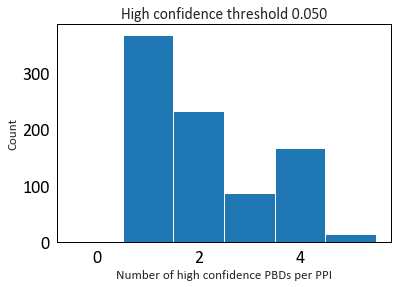

Number PPIs with >= 2 high-confidence PBDs: 497 (57.5%)


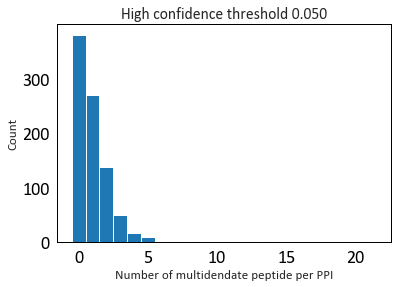

Number PPIs with 1 peptide interacting with multiple domains: 269 (31.1%)


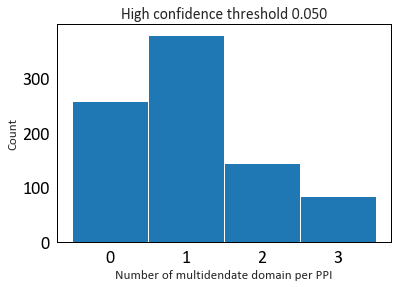

Number PPIs with 1 domain interacting with multiple peptides: 379 (43.8%)


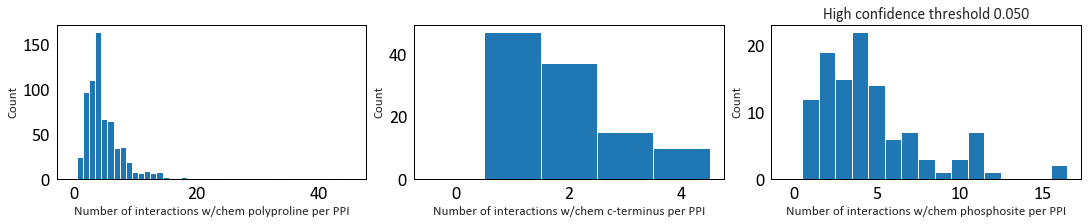


Number of PPIs that combine multiple chemistries: 21

Number of PPIs with combinations of high confidence interactions of each chemistry:
   polyproline: 647
   c-terminus: 99
   phosphosite: 97
   phosphosite,polyproline: 11
   c-terminus,polyproline: 6
   c-terminus,phosphosite: 4
   : 1
Number PPIs with multiple chemistries: 21 (2.4%)


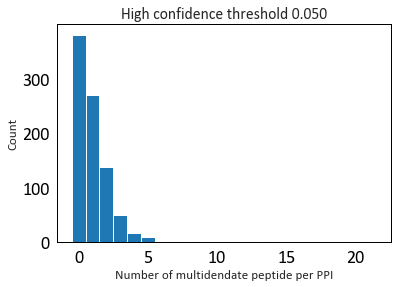

Number PPIs with at least 1 peptide that interacts with multiple domains: 485 (56.1%)


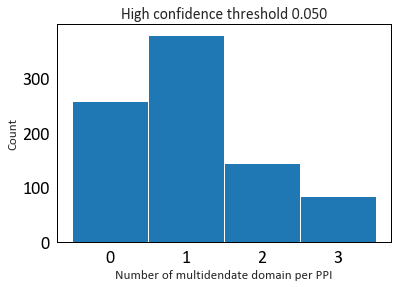

Number PPIs with at least 1 domain that interacts with multiple peptides: 608 (70.3%)


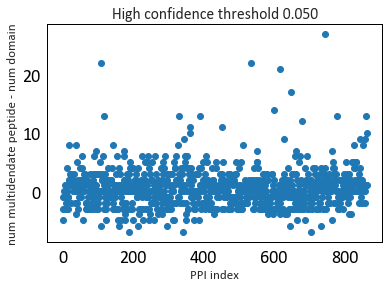

Number PPIs with number of high confidence peptides > number of domains: 402 (46.5%)


In [21]:
nppis = len(pvals)/100.0

count_high_confidence_dpi_per_ppi(pvals)

n = count_num_confident_doms(confirmed_dpidata, pvals)
print("Number PPIs with >= 2 high-confidence PBDs: %i (%.1f%%)" % (n, n/nppis))

n = count_num_multidentate_domain_or_peptide(confirmed_dpidata, pvals, dp='peptide')
print("Number PPIs with 1 peptide interacting with multiple domains: %i (%.1f%%)" % (n, n/nppis))

n = count_num_multidentate_domain_or_peptide(confirmed_dpidata, pvals, dp='domain')
print("Number PPIs with 1 domain interacting with multiple peptides: %i (%.1f%%)" % (n, n/nppis))

n = count_chemistry(confirmed_dpidata, pvals)
print("Number PPIs with multiple chemistries: %i (%.1f%%)" % (n, n/nppis))

n = count_num_multidentate_domain_or_peptide(confirmed_dpidata, pvals, dp='peptide', exclusive=False)
print("Number PPIs with at least 1 peptide that interacts with multiple domains: %i (%.1f%%)" % (n, n/nppis))

n = count_num_multidentate_domain_or_peptide(confirmed_dpidata, pvals, dp='domain', exclusive=False)
print("Number PPIs with at least 1 domain that interacts with multiple peptides: %i (%.1f%%)" % (n, n/nppis))

n = count_num_multidentate_compare_n(confirmed_dpidata, pvals, threshold_multidentate=1)
print("Number PPIs with number of high confidence peptides > number of domains: %i (%.1f%%)" % (n, n/nppis))

#### PPI architectures (Fig 3 and S4)

Examples of each PPI architecture/mechanism are shown in Fig 3 (most prevelant half of PPI architectures) and Fig S4 (least prevelant half).

A protein is described by number of domains of each type and number of peptides of each type, only considering domains/peptides on one protein that form at least 1 high-confidence interaction wtih a peptide/domain on the other protein. A PPI architecture is the set of protein descriptions.

In [22]:
from collections import *
domain_chemistry = {'PDZ': 'c-terminus', 'SH2': 'phosphosite', 'PTB': 'phosphosite', 'Kinase_TK': 'phosphosite',
                    'PTP': 'phosphosite', 'WH1': 'polyproline', 'WW': 'polyproline', 'SH3': 'polyproline'}
def count_ppi_architecture(data, ps, dom_type='family', threshold=0.05, threshold_operator=np.less_equal):
    """
    Count number of instances of each PPI architecture:
        A protein is described by number of domains of each type and number of peptides of each type.
        A PPI architecture is the set of protein descriptions.
        Domain types are either chemistry based ('chem') or PBD family ('family') based.
        
        Note: Only domains and peptides involved in at least one interaction given criteria are considered.
    """
    
    if dom_type == 'family': map_dompep_type = lambda x: x
    else: map_dompep_type = lambda x: 'binds_'+domain_chemistry[x] if x in domain_chemistry.keys() else x
        
    def count_prot_components(components):
        c = [c[0] for c in components]
        counts = frozenset((map_dompep_type(dp), c.count(dp)) for dp in set(c))
        return tuple(sorted(counts))
    
    count_per_arch = {}
    ppis_with_arch = defaultdict(list)
    for p, (uid1, uid2, interactions) in zip(ps, data):
        c1, c2 = get_ppi_composition(uid1, uid2, interactions, p,
                                     threshold=threshold, threshold_operator=threshold_operator)

        counts1 = count_prot_components(c1)
        counts2 = count_prot_components(c2)
        if len(counts1) == 0 or len(counts2) == 0: continue
        if len(counts1) == len(counts2):
            if counts1 < counts2:
                arch = (counts1, counts2)
            else: arch = (counts2, counts1)
        elif len(counts1) < len(counts2):
            arch = (counts1, counts2)
        else: arch = (counts2, counts1)

        if arch not in count_per_arch.keys(): count_per_arch[arch] = 0
        count_per_arch[arch] += 1
        ppis_with_arch[arch].append((uid1, uid2))
    
    print("Number of unique PPI architectures:", len(count_per_arch.keys()))
    count_per_arch = dict(sorted(count_per_arch.items(), key=lambda x: x[1], reverse=True))
    for arch, n in count_per_arch.items():
        print("\n%10i instances of architecture:" % n)
        p1, p2 = arch
        print('\tProtein 1:', p1)
        print('\tProtein 2:', p2)
        
    return count_per_arch, ppis_with_arch

In [23]:
count_per_arch, ppis_with_arch = count_ppi_architecture(confirmed_dpidata, pvals, dom_type='family')

Number of unique PPI architectures: 168

        58 instances of architecture:
	Protein 1: (('WW', 4),)
	Protein 2: (('polyproline', 1),)

        53 instances of architecture:
	Protein 1: (('WW', 2),)
	Protein 2: (('polyproline', 2),)

        48 instances of architecture:
	Protein 1: (('WW', 4),)
	Protein 2: (('polyproline', 2),)

        43 instances of architecture:
	Protein 1: (('PDZ', 1),)
	Protein 2: (('c-terminus', 1),)

        33 instances of architecture:
	Protein 1: (('WW', 1),)
	Protein 2: (('polyproline', 2),)

        33 instances of architecture:
	Protein 1: (('PDZ', 2),)
	Protein 2: (('c-terminus', 1),)

        32 instances of architecture:
	Protein 1: (('WH1', 1),)
	Protein 2: (('polyproline', 3),)

        31 instances of architecture:
	Protein 1: (('WW', 2),)
	Protein 2: (('polyproline', 3),)

        28 instances of architecture:
	Protein 1: (('WW', 2),)
	Protein 2: (('polyproline', 1),)

        28 instances of architecture:
	Protein 1: (('WW', 1),)
	Protein 2: (

Protein composition data must be added to dpi_data output by HSM/P (which does not maintain assignment of domains and peptides to each protein). This is needed to create PPI schematics for Fig 3 and Fig S4.

In [24]:
schematic_keys = {'phosphosite': 'Phosphosite', 'polyproline' : 'Proline', 'c-terminus': 'CTerm'}
def format_protein_data_for_schematics(uid, protdata):
    s = []
    scterm = [] # always put c-terminus last (otherwise they are unordered)
    for (t, seq) in protdata:
        if t in schematic_keys.keys(): k = schematic_keys[t]
        else: k = t
        if k == 'CTerm': scterm.append('{"%s", "%s", "%s"}' % (k, seq, uid))
        else: s.append('{"%s", "%s", "%s"}' % (k, seq, uid))
    s += scterm
    return ','.join(s)
    
def format_interaction_data_for_schematics(uid1, uid2, comp1, comp2, interactions, p,
                                           self_interaction=False,
                                           threshold=0.05, threshold_operator=np.less_equal):
    comp1 = [c[1] for c in comp1]
    comp2 = [c[1] for c in comp2]
    s = []
    for ip, i in zip(p, interactions):
        if threshold_operator(ip, threshold):
            i1, i2, prob = i
            if i1[1] in comp1: u1, u2 = uid1, uid2
            else: u1, u2 = uid2, uid1
            s1 = format_protein_data_for_schematics(u1, [i1])
            s2 = format_protein_data_for_schematics(u2, [i2])
            s.append('{%s, %s, %.4f}' % (s1, s2, prob))
            if self_interaction:
                s1 = format_protein_data_for_schematics(u2, [i1])
                s2 = format_protein_data_for_schematics(u1, [i2])
                s.append('{%s, %s, %.4f}' % (s1, s2, prob))
    return ','.join(s)
    
def format_ppi_data_for_schematics(uid1, uid2, interactions, p, threshold=0.05, threshold_operator=np.less_equal):
    p1, p2 = get_ppi_composition(uid1, uid2, interactions, p,
                                 threshold=threshold, threshold_operator=threshold_operator)
    
    self_interaction=False
    if uid1 == uid2:
        uid1 += '-A'
        uid2 += '-B'
        self_interaction=True
    
    # first entry of every interaction array is protein data
    sp1 = format_protein_data_for_schematics(uid1, p1)
    sp2 = format_protein_data_for_schematics(uid2, p2)
    
    # second entry is interaction data
    si = format_interaction_data_for_schematics(uid1, uid2, p1, p2, interactions, p, self_interaction=self_interaction)
    return '{%s}, {%s}' % (sp1, sp2), si

Examples chosen for the top 50% most prevalent architecture to show in Fig 3 (bottom 50% in Fig 4). For each architecture, the PPI with the highest predicted HSM/P probability is picked as an example.

In [25]:
ex_top, ex_bot = {}, {}
rank_per_arch = {k: i for i, k in enumerate(count_per_arch.keys())}
cutoff = len(count_per_arch)/2-1

for k, vs in ppis_with_arch.items():
    ppi1d = np.array([','.join(sorted([v[0], v[1]])) for v in vs])
    mask = np.isin(confirmed_ppis, ppi1d)
    i = np.argmax(confirmed_probs[mask])
    if rank_per_arch[k] <= cutoff: ex_top[k] = confirmed_ppis[mask][i]
    else: ex_bot[k] = confirmed_ppis[mask][i]

In [26]:
# sorting by total size of PPI (# PBDs + # peptides)
def create_mathematica_array(exs):
    str_ex = []
    for k, ex in sorted(exs.items(), key=lambda x: sum(a[1] for b in x[0] for a in b)):
        ndx = np.where(confirmed_ppis == ex)[0][0]
        data = confirmed_dpidata[ndx]
        sp, si = format_ppi_data_for_schematics(data[0], data[1], data[2], pvals[ndx])
        sc = '"%i"' % count_per_arch[k] if count_per_arch[k] > 1 else '""'
        s = '{%s, {%s}, %s}' % (sp, si, sc)
        str_ex.append(s)

    return '{%s}' % ','.join(str_ex)

output_directory = 'plots/fig_3_supp_fig_4'
if not os.path.exists(output_directory): os.makedirs(output_directory)
    
s = create_mathematica_array(ex_top)
with open(os.path.join(output_directory, 'confirmed_ppi_architectures.most_prevalent_half.txt'), 'w') as f:
    f.write("topInteractions = %s;" % s)

s = create_mathematica_array(ex_bot)
with open(os.path.join(output_directory, 'confirmed_ppi_architectures.least_prevalent_half.txt'), 'w') as f:
    f.write("botInteractions = %s;" % s)